In [1]:
%load_ext autoreload
%autoreload 2
from collections import Counter
from typing import List

import matplotlib.pyplot as plt
import pandas as pd
import seaborn as sns
from gensim.models.word2vec import Word2VecKeyedVectors

from songrecsys import *

/home/suchygrzech/repos/pwr/s3/pisr/p/.env/lib/python3.7/site-packages/tqdm/autonotebook/__init__.py:14: TqdmExperimentalWarning: Using `tqdm.autonotebook.tqdm` in notebook mode. Use `tqdm.tqdm` instead to force console mode (e.g. in jupyter console)
  " (e.g. in jupyter console)", TqdmExperimentalWarning)


In [2]:
sns.set_style('white')
sns.set_context("notebook", rc={'lines.linewidth': 5})

data: Data = load(DataFormat.pickle)
mgr = Manager(['spotify'], LyricsGenius, data, override=True)
pisr = PISR(mgr)
data = pisr.get_playlist_pairs()

Loading pickle from data/data... OK
Loading config from config.json
Loading corpus from data/corpus.txt


In [5]:
def get_preds(max_epochs:int) -> pd.DataFrame:
    df_data = {'epoch': [], 'track_cnt': []}
    for epoch in tqdm(list(range(1, max_epochs + 1)), 'Gathering data'):
        model: Word2VecKeyedVectors = pisr.get_model(epochs=epoch)
        playlist: List[str] = data[0]
        song: str = playlist[0]
        songs = model.most_similar(song, topn=50)
        songs_cnt = sum([pred_song[0] in playlist and pred_song[0] != song for pred_song in songs])
        
        df_data['epoch'].append(epoch)
        df_data['track_cnt'].append(songs_cnt)
    df_data = pd.DataFrame.from_dict(df_data)
    return df_data

In [26]:
def plot(df_data: pd.DataFrame):
    plt.figure(figsize=(16, 9))
    return sns.barplot(data=df_data, x='epoch', y='track_cnt')

epoch        146
track_cnt     20
Name: 145, dtype: int64

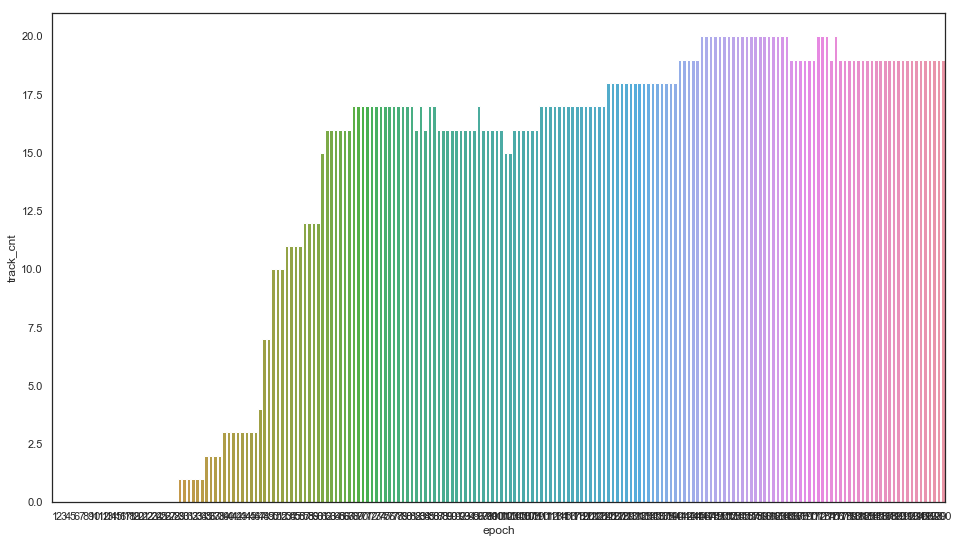

In [27]:
# df_data  = get_preds(200)
plot(df_data)
df_data.iloc[df_data.idxmax(axis=0).track_cnt]

In [11]:
model = pisr.get_model(epochs=200)

carry on
[('i could get used to this', 0.9984147548675537), ('all day and night', 0.9957770109176636), ('monopoly', 0.9955153465270996), ('never go back', 0.9954159259796143), ('speaker', 0.9952096343040466), ('so am i', 0.9918569326400757), ('sing it with me', 0.9863243699073792), ('hp', 0.9858677983283997), ('i miss myself', 0.9847334623336792), ("if i can't have you", 0.9841680526733398)]
['drive', 'praise you', 'show me love', 'old friend', 'all day and night', 'carry on', 'make your move', 'losing it', 'lullaby', 'feel alive', 'go bang', 'high on life', 'i could get used to this', 'sos', 'so close', 'beautiful life', 'grapevine', 'tidal wave', 'selfish', 'breathe', 'open end resource', 'this groove', 'bones', 'nobody else', 'save me tonight', 'favorite sound', 'mistaken', 'changa', 'fire in my soul', 'brave', "better when you're gone", 'speechless', 'tim', 'don’t feel like crying', 'piece of your heart', 'no sleep', 'time', 'all over the world', 'halfway there', 'white lies', "i'm

In [53]:
playlist = data[1]
song = playlist[3]
playlist

['i like girls',
 'middle child',
 'speed it up',
 'floating',
 'die young',
 'middle child',
 'shotta flow',
 'goin baby',
 'big ole freak',
 'act up',
 'west coast',
 'racks in the middle',
 'enzo',
 'put a date on it',
 'have mercy',
 'chopstix',
 'light it up',
 'feeling',
 'go loko',
 'tic toc',
 "that's a rack",
 'slide',
 'sanguine paradise',
 'swervin',
 'going bad',
 'pure water',
 'homicide',
 'a lot',
 'clout',
 'i',
 'stop snitchin',
 'red room',
 'goddamn',
 'vossi bop',
 'price on my head',
 'thotiana',
 'same yung nigga',
 'robbery',
 'faucet failure',
 'envy me',
 'make believe',
 'numb numb juice',
 'slime belief',
 'legacy',
 'pop out',
 'suge',
 'wow.',
 'first off',
 'freaky',
 'mixed personalities']

In [58]:
wrong, true = [], []
for idx, pred_song in enumerate(model.most_similar(song, topn=15)):
    if pred_song[0] in playlist and pred_song[0] != song:
        print(f'{idx}.', pred_song, 'is in playlist')
        true.append(pred_song[0])
    else:
        wrong.append(pred_song[0])
len(true)/(len(wrong)+len(true))

0. ('die young', 0.9981858730316162) is in playlist
1. ('speed it up', 0.9976639747619629) is in playlist
2. ('middle child', 0.9974575638771057) is in playlist
3. ('enzo', 0.9944660663604736) is in playlist
4. ('i like girls', 0.994419515132904) is in playlist
5. ('act up', 0.9934871792793274) is in playlist
6. ('shotta flow', 0.9934458136558533) is in playlist
7. ('put a date on it', 0.9927949905395508) is in playlist
8. ('racks in the middle', 0.9926286935806274) is in playlist
9. ('goin baby', 0.9924365282058716) is in playlist
10. ('big ole freak', 0.9923134446144104) is in playlist


0.7333333333333333